## Libraries

In [1]:
import numpy as np
import pandas as pd
import json
import time
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.io as sio
import os
from os import listdir
from PIL import Image, ImageDraw as D
from os.path import dirname, join as pjoin
import cv2
from tensorflow.keras.applications.vgg16 import preprocess_input

# FDST Dataset
Fudan-ShanghaiTech is a large-scale video crowd counting dataset that has been introduced because existing video crowd counting datasets were too small in terms of number of both frames as well as scenes.

It contains 100 videos captured from 13 different scenes. FDST includes 150,000 frames and 394,081 annotated heads. The training set of the FDST dataset consists of 60 videos, 9000 frames, and the testing set contains the remaining 40 videos, 6000 frames. The number of frames per second (FPS) for FDST is 30.

*Folders 31-33* and *41-43* have a lower resolution than the others (1280×720 and not 1920×1080), but since we are resizing all frames to 640×360 pixels this won't be a problem.

It is taken from https://github.com/sweetyy83/Lstn_fdst_dataset

## Images

In [11]:
def load_dataset_jpg(path_data):
    full_list = []
    for path in os.listdir(path_data):
        # Append images to a list
        list_images = []
        for item in os.listdir(path_data+"/"+path+"/"):
            if os.path.isfile(path_data+"/"+path+"/"+item) & (item.endswith(".jpg")) & (not item.startswith("._")):
                im = Image.open(path_data+"/"+path+"/"+item).convert("RGB")
                new_image = im.resize((640, 360))
                im = np.array(new_image)
                #print(f"Image: {item}, shape: {im.shape}")
                list_images.append(im)
        full_list.append(np.array(list_images))    
    return full_list

In [2]:
# train_FDST = load_dataset_jpg('Dataset/FDST/train_data/')
# np.save("train_FDST.npy", train_FDST)
# test_FDST = load_dataset_jpg('Dataset/FDST/test_data/')
# np.save("test_FDST.npy", test_FDST)
train_FDST = np.load("train_FDST.npy")
test_FDST = np.load("test_FDST.npy")
print("train_FDST shape: {}\ntest_FDST shape: {}".format(train_FDST.shape, test_FDST.shape))

## Ground truth and labels

In [ ]:
# create json for ALL train data
path_data = "Dataset/FDST/train_data"
gt_dict = {}
for path in os.listdir(path_data):
    folder_dict = {}
    for item in os.listdir(path_data+"/"+path+"/"):
        if os.path.isfile(path_data+"/"+path+"/"+item) & (item.endswith(".json")) & (not item.startswith("._")):
            f = open(path_data+"/"+path+"/"+item)
            js = json.load(f)
            heads_list = []
            for i in range(len(js[next(iter(js))]["regions"])):
                head_position = []
                for value in js[next(iter(js))]["regions"][i]['shape_attributes'].values():
                    if value != "rect":
                        head_position.append(value)
                heads_list.append(head_position)
                folder_dict[item[:-5]] = heads_list
            gt_dict[path] = folder_dict

# Save it as a single json for train           
with open("gt_json_train.json", "w") as file:
    json.dump(gt_dict, file)

In [3]:
# create json for ALL test data
path_data = "Dataset/FDST/test_data"
gt_dict = {}
for path in os.listdir(path_data):
    folder_dict = {}
    for item in os.listdir(path_data+"/"+path+"/"):
        if os.path.isfile(path_data+"/"+path+"/"+item) & (item.endswith(".json")) & (not item.startswith("._")):
            f = open(path_data+"/"+path+"/"+item)
            js = json.load(f)
            heads_list = []
            for i in range(len(js[next(iter(js))]["regions"])):
                head_position = []
                for value in js[next(iter(js))]["regions"][i]['shape_attributes'].values():
                    if value != "rect":
                        head_position.append(value)
                heads_list.append(head_position)
                folder_dict[item[:-5]] = heads_list
            gt_dict[path] = folder_dict

# Save it as a single json for test           
with open("gt_json_test.json", "w") as file:
    json.dump(gt_dict, file)

In [3]:
# load json train and scale it accordingly to img resizing
f = open("gt_json_train.json")
gt_train = json.load(f)
for i in gt_train.keys():
    if i in ["31", "32", "33", "41", "42", "43"]:
        for j in gt_train[i].keys():
            gt_train[i][j] = np.divide(gt_train[i][j], 2)
    else:
        for j in gt_train[i].keys():
            gt_train[i][j] = np.divide(gt_train[i][j], 3)

In [4]:
# load json test and scale it accordingly to img resizing
f = open("gt_json_test.json")
gt_test = json.load(f)
for i in gt_test.keys():
    if i in ["34", "35", "44", "45", "49", "50"]:
        for j in gt_test[i].keys():
            gt_test[i][j] = np.divide(gt_test[i][j], 2)
    else:
        for j in gt_test[i].keys():
            gt_test[i][j] = np.divide(gt_test[i][j], 3)

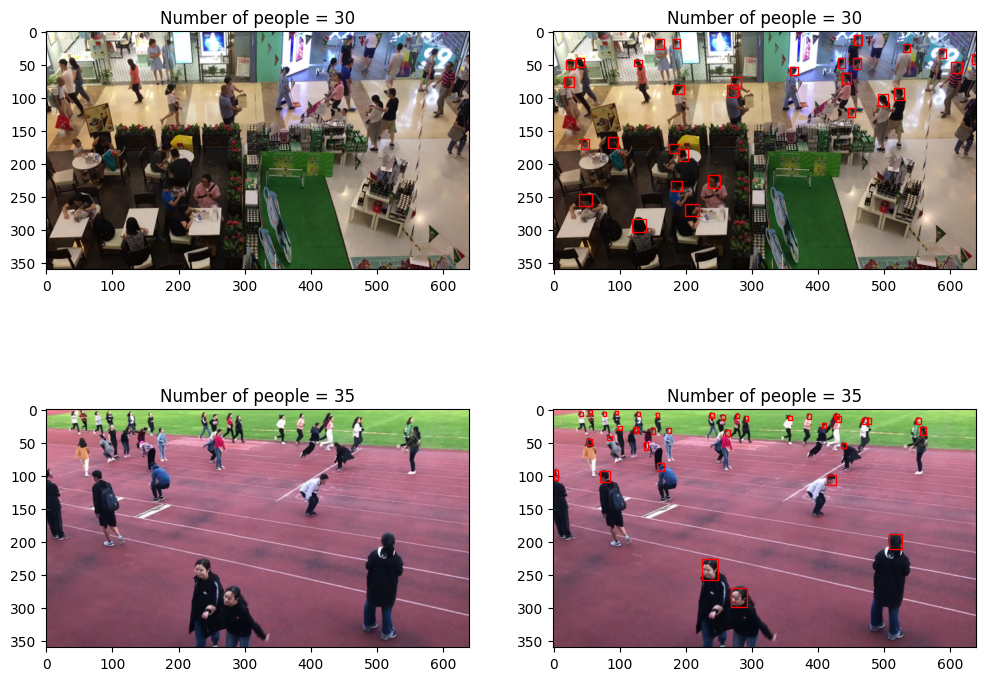

In [4]:
# lest's display 2 images with the corresponding labels and ground truth

f, ax = plt.subplots(2,2, figsize = (12, 9))

ax[0,0].imshow(train_FDST[list(gt_train.keys()).index("1")][list(gt_train["1"].keys()).index("001")])
ax[0,1].imshow(train_FDST[list(gt_train.keys()).index("1")][list(gt_train["1"].keys()).index("001")])
ax[1,0].imshow(train_FDST[list(gt_train.keys()).index("53")][list(gt_train["53"].keys()).index("150")])
ax[1,1].imshow(train_FDST[list(gt_train.keys()).index("53")][list(gt_train["53"].keys()).index("150")])

# adding ground truth
for x, y, w, h in gt_train["1"]["001"]:
    ax[0,1].add_patch(patches.Rectangle((round(x),round(y)), w, h, linewidth=1, edgecolor='r', facecolor='none'))
for x, y, w, h in gt_train["53"]["150"]:
    ax[1,1].add_patch(patches.Rectangle((round(x),round(y)), w, h, linewidth=1, edgecolor='r', facecolor='none'))

# titles
ax[0,0].set_title("Number of people = {}".format(len(gt_train["1"]["001"])))
ax[0,1].set_title("Number of people = {}".format(len(gt_train["1"]["001"])))
ax[1,0].set_title("Number of people = {}".format(len(gt_train["53"]["150"])))
_=ax[1,1].set_title("Number of people = {}".format(len(gt_train["53"]["150"])))

## Density function
To be fixed accordingly to FDST information on (x, y, w, h)

In [11]:
def densfun_train_FDST(folder_number, img_number):
    
    '''
    Input:
    - folder_number: number of the folder
    - img_number: number of the image
    '''  
          
    output = np.zeros(train_FDST[list(gt_train.keys()).index(folder_number)]
                      [list(gt_train[folder_number].keys()).index(img_number)].shape[:-1])
    x_full = gt_train[folder_number][img_number][:, 0]
    y_full = gt_train[folder_number][img_number][:, 1]
    w_full = gt_train[folder_number][img_number][:, 2]
    h_full = gt_train[folder_number][img_number][:, 3]

    for x, y, w, h in zip(x_full, y_full, w_full, h_full):
        density_img = np.zeros(train_FDST[list(gt_train.keys()).index(folder_number)]
                               [list(gt_train[folder_number].keys()).index(img_number)].shape[:-1])
        try:
            density_img[round(y): round(y) + round(h), round(x): round(x) + round(w)] = 1
        except:
            pass

        sigma = 3
        kernel_size = 3

        density_img = cv2.GaussianBlur(density_img, (kernel_size, kernel_size), sigma)
        output += density_img    
    
    return cv2.GaussianBlur(output, (11,11), sigma)

Time: 0.05352926254272461


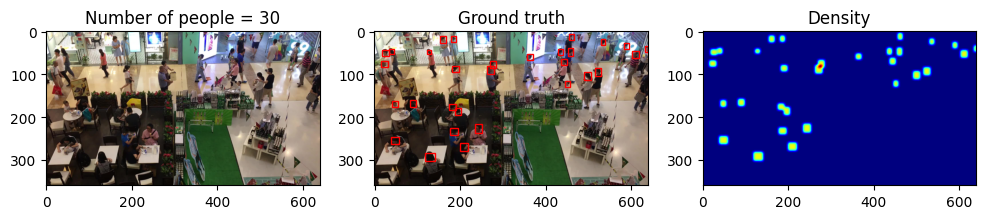

In [12]:
# density map on first image from folder 1 of FDST dataset

start = time.time()
ds = densfun_train_FDST("1", "001")
print(f"Time: {time.time() - start}")

plt.figure(figsize=(12, 9))

#image with label
plt.subplot(1, 3, 1)
plt.imshow(train_FDST[list(gt_train.keys()).index("1")][list(gt_train["1"].keys()).index("001")])
plt.title("Number of people = {}".format(len(gt_train["1"]["001"])))

# image with ground truth
plt.subplot(1, 3, 2)
plt.imshow(train_FDST[list(gt_train.keys()).index("1")][list(gt_train["1"].keys()).index("001")])
for x, y, w, h in gt_train["1"]["001"]:
    plt.gca().add_patch(patches.Rectangle((round(x),round(y)), w, h, linewidth=1, edgecolor='r', facecolor='none'))
plt.title("Ground truth")

# image with density map
plt.subplot(1, 3, 3)
plt.imshow(ds, cmap = cm.jet)
_ = plt.title("Density")

In [5]:
def densfun_test_FDST(folder_number, img_number):
    
    '''
    Input:
    - folder_number: number of the folder
    - img_number: number of the image
    '''  
          
    output = np.zeros(test_FDST[list(gt_test.keys()).index(folder_number)]
                      [list(gt_test[folder_number].keys()).index(img_number)].shape[:-1])
    x_full = gt_test[folder_number][img_number][:, 0]
    y_full = gt_test[folder_number][img_number][:, 1]
    w_full = gt_test[folder_number][img_number][:, 2]
    h_full = gt_test[folder_number][img_number][:, 3]

    for x, y, w, h in zip(x_full, y_full, w_full, h_full):
        density_img = np.zeros(test_FDST[list(gt_test.keys()).index(folder_number)]
                               [list(gt_test[folder_number].keys()).index(img_number)].shape[:-1])
        try:
            density_img[round(y): round(y) + round(h), round(x): round(x) + round(w)] = 1
        except:
            pass

        sigma = 3 
        kernel_size = 3

        density_img = cv2.GaussianBlur(density_img, (kernel_size, kernel_size), sigma)
        output += density_img    
    
    return cv2.GaussianBlur(output, (11,11), sigma)

## Density images

In [5]:
dens_train_FDST = []
for folder in gt_train.keys():
    for img in gt_train[folder].keys():
        dens_train_FDST.append(densfun_train_FDST(folder, img))
        
# Convert and save the list of density images in '.npy' format
np.save("density_train_FDST.npy", dens_train_FDST)

In [6]:
dens_test_FDST = []
for folder in gt_test.keys():
    for img in gt_test[folder].keys():
        dens_test_FDST.append(densfun_test_FDST(folder, img))
        
# Convert and save the list of density images in '.npy' format
np.save("density_test_FDST.npy", dens_test_FDST)

In [2]:
density_train_FDST = np.load("density_train_FDST.npy")
density_train_FDST.shape

(9000, 360, 640)

In [3]:
density_test_FDST = np.load("density_test_FDST.npy")
density_test_FDST.shape

(6000, 360, 640)

## Preprocessing for VGG16

In [2]:
# train_FDST = np.load("train_FDST.npy")
# test_FDST = np.load("test_FDST.npy")

In [9]:
# Preprocess first half of images for vgg16
prepro_list_1 = []
for img in train_FDST[:30]:
    prepro_img = preprocess_input(img)
    prepro_list_1.append(prepro_img)
half_prepro_train = np.array(prepro_list_1)
half_prepro_train.shape
np.save("half_prepro_train_FDST.npy", half_prepro_train)

# Preprocess second half of images for vgg16
prepro_list_2 = []
for img in train_FDST[30:]:
    prepro_img = preprocess_input(img)
    prepro_list_2.append(prepro_img)
half2_prepro_train = np.array(prepro_list_2)
half2_prepro_train.shape
np.save("half2_prepro_train_FDST.npy", half2_prepro_train)

(30, 150, 360, 640, 3)

In [3]:
# Preprocess data for vgg16

prepro_list = []

for img in test_FDST:
    prepro_img = preprocess_input(img)
    prepro_list.append(prepro_img)

prepro_test = np.array(prepro_list)
prepro_test.shape
np.save("prepro_test_FDST.npy", prepro_test)

(40, 150, 360, 640, 3)

## Validation data + Datasets divided
As validation set we take 10% of the training data, so we choose *folders 3* ([300:450]), *13* ([1200:1350]), *43* ([4050:4200]), *52* ([4650:4800]), *72* ([6450:6600]), *92* ([8250:8400]) to create it.

Split every 3 folders (450 images) to keep a reasonable size
* prepro_train
* prepro_test
* prepro_validation (on train)
* density_train
* density_validation (on train)

In [2]:
# half_prepro_train = np.load("half_prepro_train_FDST.npy")
# half2_prepro_train = np.load("half2_prepro_train_FDST.npy")
# density_train = np.load("density_train_FDST.npy")
# density_test = np.load("density_test_FDST.npy")

In [3]:
prepro_train_FDST_1 = np.array_split(half_prepro_train, [2])[0]
prepro_train_FDST_2 = np.array_split(half_prepro_train, [3, 8])[1]
prepro_train_FDST_3 = np.array_split(half_prepro_train, [9, 27])[1]
prepro_train_FDST_4 = np.array_split(half_prepro_train, [28])[1]
prepro_train_FDST_5 = np.array_split(half2_prepro_train, [1])[0]
prepro_train_FDST_6 = np.array_split(half2_prepro_train, [2, 13])[1]
prepro_train_FDST_7 = np.array_split(half2_prepro_train, [14, 25])[1]
prepro_train_FDST_8 = np.array_split(half2_prepro_train, [26])[1]

prepro_train_FDST = np.concatenate((prepro_train_FDST_1, prepro_train_FDST_2, prepro_train_FDST_3,
                                    prepro_train_FDST_4, prepro_train_FDST_5, prepro_train_FDST_6,
                                    prepro_train_FDST_7, prepro_train_FDST_8))

for i in range(17):
    np.save(f"prepro_train_FDST_{i+1}.npy", np.array_split(prepro_train_FDST, 17)[i]) # in 17 files

In [26]:
prepro_train_val_FDST_1 = np.array_split(half_prepro_train, [2, 3])[1] # folder 3
prepro_train_val_FDST_2 = np.array_split(half_prepro_train, [8, 9])[1] # folder 13
prepro_train_val_FDST_3 = np.array_split(half_prepro_train, [27, 28])[1] # folder 43
prepro_train_val_FDST_4 = np.array_split(half2_prepro_train, [1, 2])[1] # folder 52
prepro_train_val_FDST_5 = np.array_split(half2_prepro_train, [13, 14])[1] # folder 72
prepro_train_val_FDST_6 = np.array_split(half2_prepro_train, [25, 26])[1] # folder 92

prepro_train_val_FDST = np.concatenate((prepro_train_val_FDST_1, prepro_train_val_FDST_2,
                                        prepro_train_val_FDST_3, prepro_train_val_FDST_4,
                                        prepro_train_val_FDST_5, prepro_train_val_FDST_6))

for i in range(2):
    np.save(f"prepro_train_val_FDST_{i+1}.npy", np.array_split(prepro_train_val_FDST, 2)[i])

In [ ]:
density_train_FDST = np.concatenate((density_train[:300], density_train[450:1200], density_train[1350:4050],
                                     density_train[4200:4650], density_train[4800:6450],
                                     density_train[6600:8250], density_train[8400:]))

for i in range(9):
    np.save(f"density_train_FDST_{i+1}.npy", np.array_split(density_train_FDST, 9)[i])        

In [8]:
density_train_val_FDST = np.concatenate((density_train[300:450], density_train[1200:1350],
                                         density_train[4050:4200], density_train[4650:4800],
                                         density_train[6450:6600], density_train[8250:8400]))
np.save("density_train_val_FDST.npy", density_train_val_FDST)  

## Extra

In [ ]:
# check resolution of all the images
for n in range(1, 151):
    for i in os.listdir("Dataset/FDST/train_data"):
        print(i, Image.open("Dataset/FDST/train_data/" + i + "/" + "%.3d" % n + ".jpg").size)

In [ ]:
# transform string dict keys into integer
gt_train = {int(key):gt_train[key] for key in gt_train}